In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image 

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import shap


import math

In [2]:
df = pd.read_csv("../../Data/df_standardised_end_test_6hr.csv")
df = df.drop(columns = ["Unnamed: 0","X","X1.hr","X2.hr","X3.hr","X5.hr","X6.hr","X7.hr","X8.hr","X9.hr","X10.hr"
                        ,"X11.hr","X12.hr","X13.hr","X14.hr","X15.hr","X16.hr","X17.hr","X18.hr","X19.hr"
                        ,"X20.hr","X21.hr","X22.hr","X23.hr","X24.hr","X25.hr","X26.hr","X27.hr","X28.hr","chunk"])
df

,abnormal,X4.hr,train_test
0,0,-0.437480,train
1,0,-0.024752,train
2,0,-1.372619,train
3,0,-0.601068,train
4,0,0.417116,train
...,...,...,...
31653,0,1.253461,test
31654,0,0.514161,test
31655,0,-0.053325,test
31656,0,-0.091542,test


In [3]:
train = df.loc[df['train_test'] == "train"]
test = df.loc[df['train_test'] == "test"]

In [4]:
y_train = train.pop("abnormal")
X_train = train
X_train = X_train.drop(columns = ["train_test"])
y_test = test.pop("abnormal")
X_test = test
X_test = X_test.drop(columns = ["train_test"])

In [5]:
def get_results(truth, prediction, df, idx):
    

    acc = accuracy_score(truth, prediction)
    f1 = f1_score(truth, prediction)
    precision = precision_score(truth, prediction)
    recall = recall_score(truth, prediction)

    df.loc[idx,:] = [acc, f1, precision, recall]

    return df


In [6]:
results = pd.DataFrame(index = ['Decision Tree'], 
                       columns = ['accuracy', 'f1', 'precision', 'recall'])

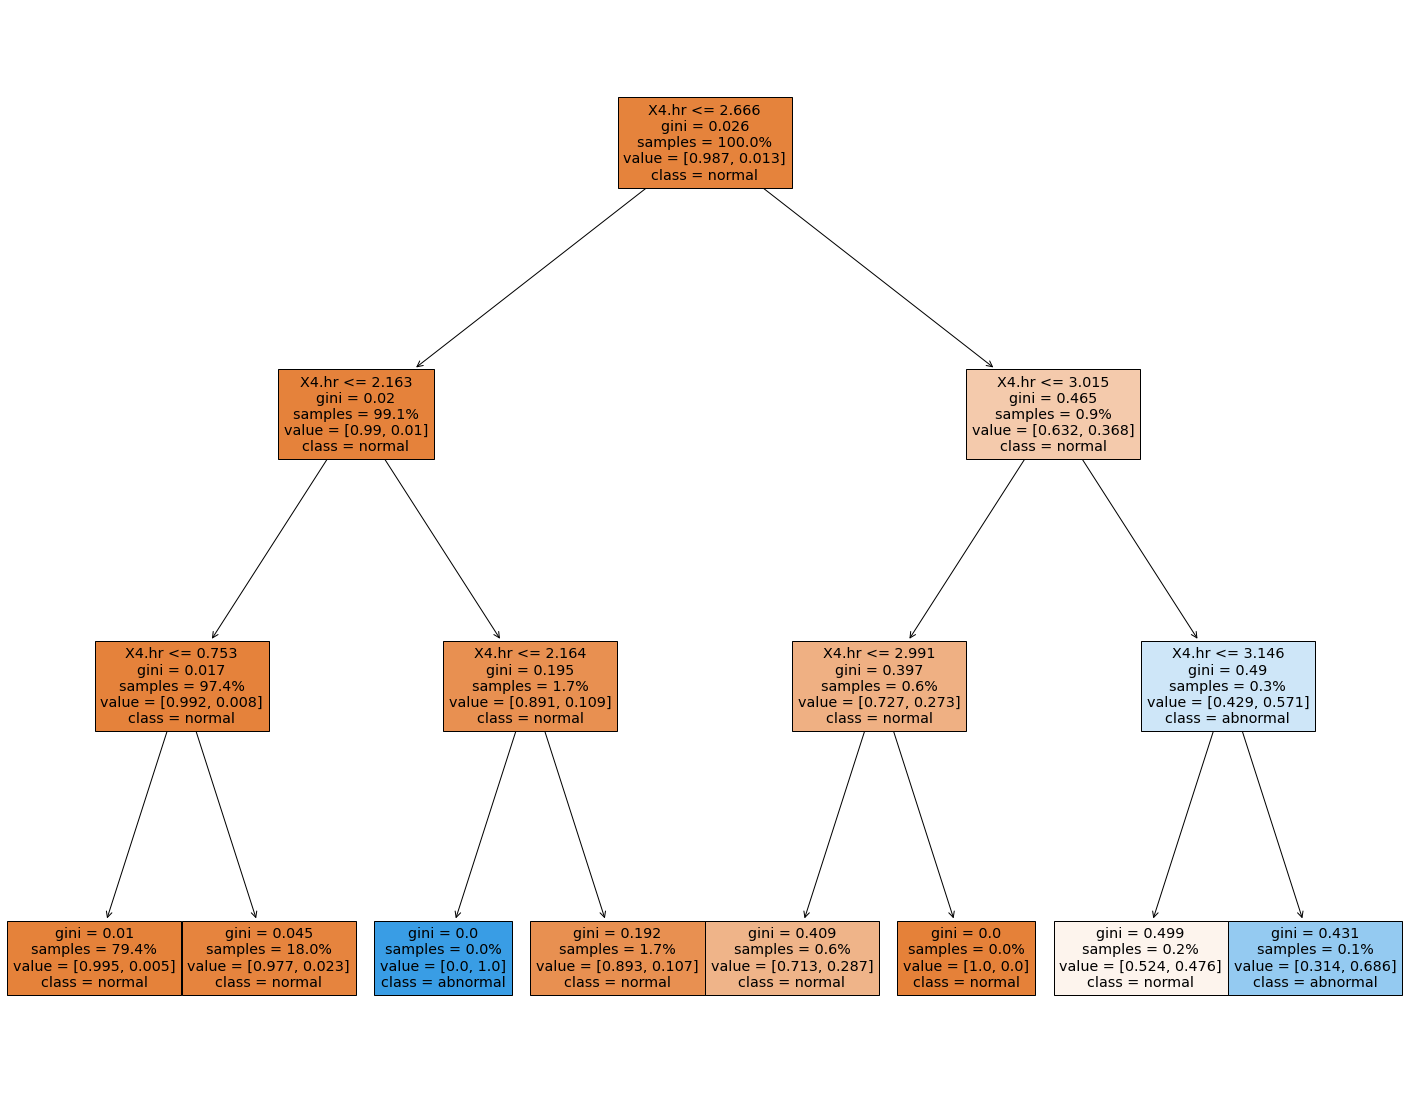

In [7]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 13)
clf.fit(X=X_train,y=y_train)

y_pred = clf.predict(X_test)

results = get_results(y_test, y_pred, results, 'Decision Tree')


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X_train.columns,  
                   class_names=['normal', 'abnormal'],
                   filled=True,  proportion = True)


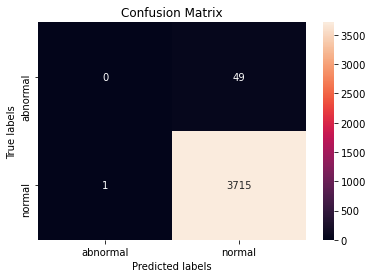

In [8]:
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['abnormal', 'normal']); 
ax.yaxis.set_ticklabels(['abnormal', 'normal'])

plt.show()

In [9]:
results

,accuracy,f1,precision,recall
Decision Tree,0.98672,0,0,0


In [10]:
for i in range(100):
    clf = DecisionTreeClassifier(max_depth = 3, class_weight={0:1, 1:i}, random_state = 13)
    clf.fit(X=X_train,y=y_train)

    y_pred = clf.predict(X_test)

    results = get_results(y_test, y_pred, results, i)


    #fig = plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(clf, 
                   #feature_names=X_train.columns,  
                   #class_names=['normal', 'abnormal'],
                   #filled=True,  proportion = True)


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [11]:
results.sort_values('f1', ascending=False)

,accuracy,f1,precision,recall
23,0.974502,0.323944,0.247312,0.469388
12,0.974502,0.323944,0.247312,0.469388
24,0.974502,0.323944,0.247312,0.469388
22,0.974502,0.323944,0.247312,0.469388
20,0.974502,0.323944,0.247312,0.469388
...,...,...,...,...
56,0.802922,0.095122,0.0505837,0.795918
99,0.637981,0.0632302,0.0327169,0.938776
0,0.986985,0,0,0
1,0.98672,0,0,0


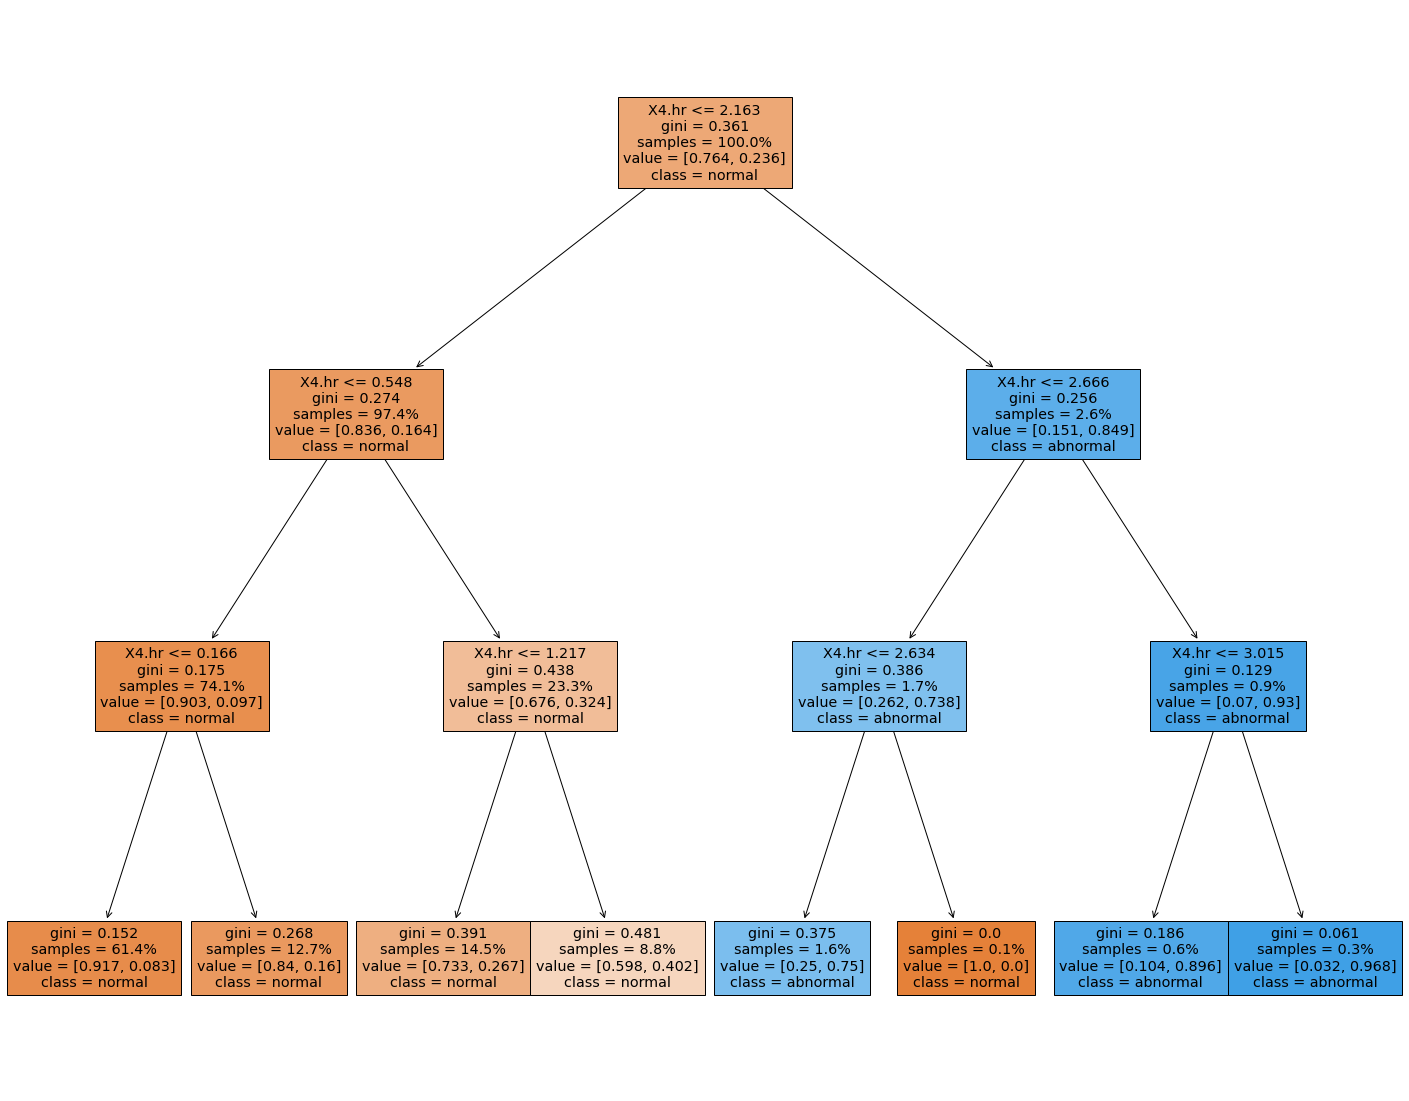

In [12]:
clf = DecisionTreeClassifier(max_depth = 3, class_weight={0:1, 1:23}, random_state = 13)
clf.fit(X=X_train,y=y_train)

y_pred = clf.predict(X_test)

results = get_results(y_test, y_pred, results, i)


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                feature_names=X_train.columns,  
                class_names=['normal', 'abnormal'],
                filled=True,  proportion = True)

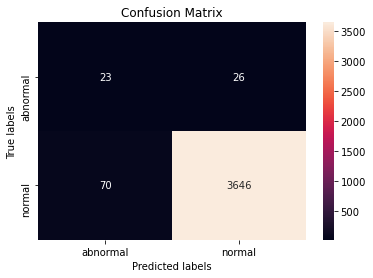

In [13]:
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['abnormal', 'normal']); 
ax.yaxis.set_ticklabels(['abnormal', 'normal'])

plt.show()

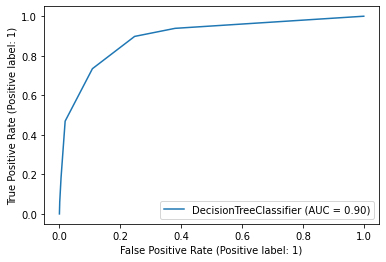

In [14]:
plot_roc_curve(clf,X_test,y_test)
plt.show()

In [15]:
y_score = clf.predict_proba(X_test)

In [16]:
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ["index"])
y_test = y_test.squeeze()

y_pred = pd.Series(y_pred)

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_test[indices], y_score[indices, 1])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))


sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Bootstrap #1 ROC area: 0.834
Bootstrap #2 ROC area: 0.919
Bootstrap #3 ROC area: 0.916
Bootstrap #4 ROC area: 0.911
Bootstrap #5 ROC area: 0.919
Bootstrap #6 ROC area: 0.867
Bootstrap #7 ROC area: 0.906
Bootstrap #8 ROC area: 0.904
Bootstrap #9 ROC area: 0.900
Bootstrap #10 ROC area: 0.894
Bootstrap #11 ROC area: 0.899
Bootstrap #12 ROC area: 0.888
Bootstrap #13 ROC area: 0.892
Bootstrap #14 ROC area: 0.912
Bootstrap #15 ROC area: 0.895
Bootstrap #16 ROC area: 0.901
Bootstrap #17 ROC area: 0.899
Bootstrap #18 ROC area: 0.865
Bootstrap #19 ROC area: 0.881
Bootstrap #20 ROC area: 0.877
Bootstrap #21 ROC area: 0.892
Bootstrap #22 ROC area: 0.906
Bootstrap #23 ROC area: 0.906
Bootstrap #24 ROC area: 0.937
Bootstrap #25 ROC area: 0.898
Bootstrap #26 ROC area: 0.894
Bootstrap #27 ROC area: 0.904
Bootstrap #28 ROC area: 0.890
Bootstrap #29 ROC area: 0.909
Bootstrap #30 ROC area: 0.835
Bootstrap #31 ROC area: 0.949
Bootstrap #32 ROC area: 0.907
Bootstrap #33 ROC area: 0.889
Bootstrap #34 ROC a

Bootstrap #306 ROC area: 0.903
Bootstrap #307 ROC area: 0.920
Bootstrap #308 ROC area: 0.904
Bootstrap #309 ROC area: 0.914
Bootstrap #310 ROC area: 0.875
Bootstrap #311 ROC area: 0.854
Bootstrap #312 ROC area: 0.891
Bootstrap #313 ROC area: 0.866
Bootstrap #314 ROC area: 0.935
Bootstrap #315 ROC area: 0.943
Bootstrap #316 ROC area: 0.877
Bootstrap #317 ROC area: 0.849
Bootstrap #318 ROC area: 0.895
Bootstrap #319 ROC area: 0.891
Bootstrap #320 ROC area: 0.851
Bootstrap #321 ROC area: 0.905
Bootstrap #322 ROC area: 0.918
Bootstrap #323 ROC area: 0.897
Bootstrap #324 ROC area: 0.906
Bootstrap #325 ROC area: 0.894
Bootstrap #326 ROC area: 0.891
Bootstrap #327 ROC area: 0.898
Bootstrap #328 ROC area: 0.885
Bootstrap #329 ROC area: 0.869
Bootstrap #330 ROC area: 0.933
Bootstrap #331 ROC area: 0.865
Bootstrap #332 ROC area: 0.858
Bootstrap #333 ROC area: 0.897
Bootstrap #334 ROC area: 0.878
Bootstrap #335 ROC area: 0.831
Bootstrap #336 ROC area: 0.886
Bootstrap #337 ROC area: 0.928
Bootstra

Bootstrap #614 ROC area: 0.870
Bootstrap #615 ROC area: 0.900
Bootstrap #616 ROC area: 0.887
Bootstrap #617 ROC area: 0.901
Bootstrap #618 ROC area: 0.890
Bootstrap #619 ROC area: 0.912
Bootstrap #620 ROC area: 0.880
Bootstrap #621 ROC area: 0.883
Bootstrap #622 ROC area: 0.912
Bootstrap #623 ROC area: 0.881
Bootstrap #624 ROC area: 0.912
Bootstrap #625 ROC area: 0.858
Bootstrap #626 ROC area: 0.922
Bootstrap #627 ROC area: 0.894
Bootstrap #628 ROC area: 0.904
Bootstrap #629 ROC area: 0.855
Bootstrap #630 ROC area: 0.858
Bootstrap #631 ROC area: 0.925
Bootstrap #632 ROC area: 0.845
Bootstrap #633 ROC area: 0.888
Bootstrap #634 ROC area: 0.836
Bootstrap #635 ROC area: 0.919
Bootstrap #636 ROC area: 0.888
Bootstrap #637 ROC area: 0.918
Bootstrap #638 ROC area: 0.907
Bootstrap #639 ROC area: 0.910
Bootstrap #640 ROC area: 0.881
Bootstrap #641 ROC area: 0.883
Bootstrap #642 ROC area: 0.888
Bootstrap #643 ROC area: 0.882
Bootstrap #644 ROC area: 0.922
Bootstrap #645 ROC area: 0.895
Bootstra

Bootstrap #922 ROC area: 0.900
Bootstrap #923 ROC area: 0.855
Bootstrap #924 ROC area: 0.903
Bootstrap #925 ROC area: 0.913
Bootstrap #926 ROC area: 0.827
Bootstrap #927 ROC area: 0.893
Bootstrap #928 ROC area: 0.896
Bootstrap #929 ROC area: 0.859
Bootstrap #930 ROC area: 0.934
Bootstrap #931 ROC area: 0.909
Bootstrap #932 ROC area: 0.942
Bootstrap #933 ROC area: 0.930
Bootstrap #934 ROC area: 0.893
Bootstrap #935 ROC area: 0.929
Bootstrap #936 ROC area: 0.884
Bootstrap #937 ROC area: 0.896
Bootstrap #938 ROC area: 0.915
Bootstrap #939 ROC area: 0.894
Bootstrap #940 ROC area: 0.928
Bootstrap #941 ROC area: 0.895
Bootstrap #942 ROC area: 0.904
Bootstrap #943 ROC area: 0.894
Bootstrap #944 ROC area: 0.935
Bootstrap #945 ROC area: 0.916
Bootstrap #946 ROC area: 0.867
Bootstrap #947 ROC area: 0.904
Bootstrap #948 ROC area: 0.899
Bootstrap #949 ROC area: 0.829
Bootstrap #950 ROC area: 0.879
Bootstrap #951 ROC area: 0.908
Bootstrap #952 ROC area: 0.915
Bootstrap #953 ROC area: 0.878
Bootstra